# CA Coronavirus Cases and Deaths Trends

CA's [Blueprint for a Safer Economy](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) assigns each county [to a tier](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) based on case rate and test positivity rate. If counties fall into 2 different tiers on the two metrics, they are assigned to the more restrictive tier. What's opened / closed [under each tier](https://www.cdph.ca.gov/Programs/CID/DCDC/CDPH%20Document%20Library/COVID-19/Dimmer-Framework-August_2020.pdf).

Tiers, from most severe to least severe, categorizes coronavirus spread as <strong><span style='color:#6B1F84'>widespread; </span></strong>
<strong><span style='color:#F3324C'>substantial; </span></strong><strong><span style='color:#F7AE1D'>moderate; </span></strong><strong><span style = 'color:#D0E700'>or minimal.</span></strong>
**Counties must stay in the current tier for 3 consecutive weeks and metrics from the last 2 consecutive weeks must fall into less restrictive tier before moving into a less restrictive tier.**

Case charts are labeled with the tier cut-offs after adjusting for the county's population.

In [1]:
import altair as alt
import altair_saver
import os
import pandas as pd

import default_parameters
import make_charts
import us_county_utils

from IPython.display import display_html, Markdown, HTML

# Default parameters
time_zone = default_parameters.time_zone
start_date = default_parameters.start_date
today_date = default_parameters.today_date

In [2]:
STATE = "CA"

jhu = us_county_utils.clean_jhu(start_date)
jhu = jhu[jhu.state_abbrev==STATE]

hospitalizations = us_county_utils.clean_hospitalizations(start_date)

ca_counties = list(jhu[jhu.state_abbrev==STATE].county.unique())   

In [3]:
title_font_size = 9
font_name = make_charts.font_name
grid_opacity = make_charts.grid_opacity
domain_opacity = make_charts.domain_opacity
stroke_opacity = make_charts.stroke_opacity
chart_width = make_charts.chart_width
chart_height = make_charts.chart_height


def plot_charts(cases_df, hospital_df, county_name):
    cases_df = cases_df[cases_df.county==county_name]
    hospital_df = hospital_df[hospital_df.county==county_name].drop(columns = "date")
    
    name = cases_df.county.iloc[0]
    
    cases_chart, deaths_chart = make_charts.setup_cases_deaths_chart(cases_df, "county", name)
    hospitalizations_chart = make_charts.setup_county_covid_hospital_chart(hospital_df, county_name)
    
    chart = (alt.hconcat(cases_chart, deaths_chart, hospitalizations_chart)
             .configure_title(
                 fontSize=title_font_size, font=font_name, anchor="middle", color="black"
             ).configure_axis(
                 gridOpacity=grid_opacity, domainOpacity=domain_opacity
             ).configure_view(strokeOpacity=stroke_opacity)
            )
    
    
    county_state_name = county_name + f", {STATE}"
    display(Markdown(f"## {county_state_name}"))
    
    make_charts.show_svg(chart)

## Counties by Region
<strong>Superior California Region: </strong> Butte, Colusa, El Dorado, Glenn, Lassen, Modoc, Nevada, Placer, Plumas, Sacramento, Shasta, Sierra, Siskiyou, Sutter, Tehama, Yolo, Yuba
<br>
<strong>North Coast:</strong> Del Norte, Humboldt, Lake, Mendocino, Napa, Sonoma, Trinity
<br>
<strong>San Francisco Bay Area:</strong> [Alameda](#alameda), 
[Contra Costa](#contra_costa), 
[Marin](#marin), 
[San Francisco](#san_francisco), 
[San Mateo](#san_mateo), 
[Santa Clara](#santa_clara), 
[Solano](#solano)
<br>
<strong>Northern San Joaquin Valley:</strong> Alpine, Amador, Calaveras, Madera, Mariposa, Merced, Mono, San Joaquin, Stanislaus, Tuolumne
<br>
<strong>Central Coast:</strong> Monterey, San Benito, San Luis Obispo, 
[Santa Barbara](#santa_barbara), 
[Santa Cruz](#santa_cruz), 
[Ventura](#ventura)
<br>
<strong>Southern San Joaquin Valley:</strong> Fresno, Inyo, Kern, Kings, Tulare
<br>
<strong>Southern California:</strong> [Los Angeles](#la), 
[Orange](#orange), 
[Riverside](#riverside), 
[San Bernardino](#san_bernardino)
<br>
<strong>San Diego-Imperial:</strong> [Imperial](#imperial), 
[San Diego](#san_diego)

Ref: [Census CA Regions](https://census.ca.gov/regions/)

<a id='la'></a>

## Los Angeles, CA

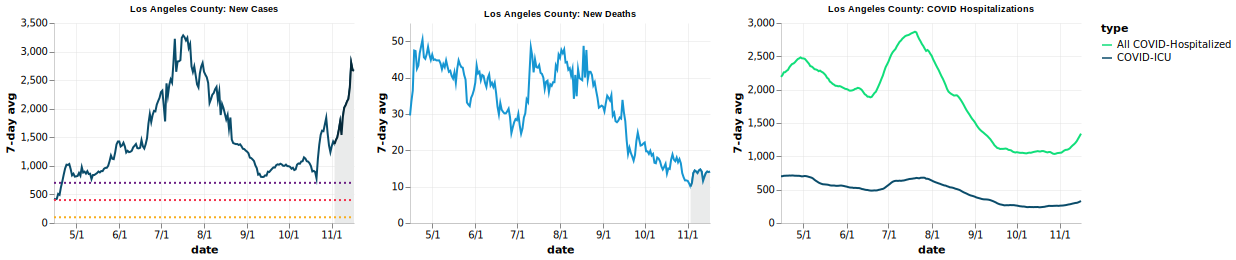

In [4]:
c = "Los Angeles"
plot_charts(jhu, hospitalizations, c)

<a id='alameda'></a>

## Alameda, CA

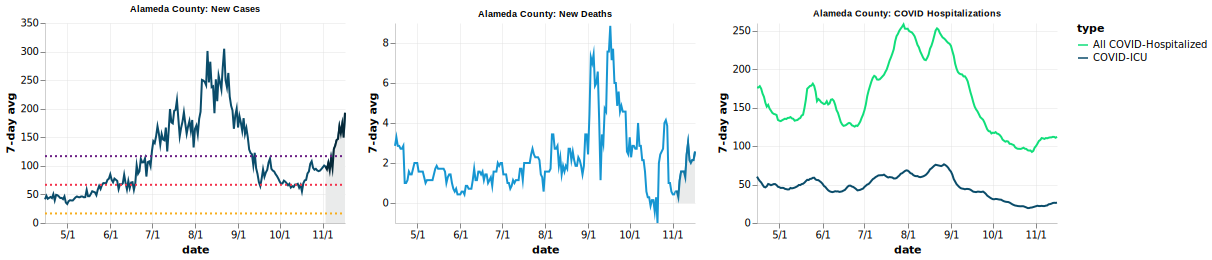

In [5]:
c = "Alameda"
plot_charts(jhu, hospitalizations, c)

<a id='contra_costa'></a>

## Contra Costa, CA

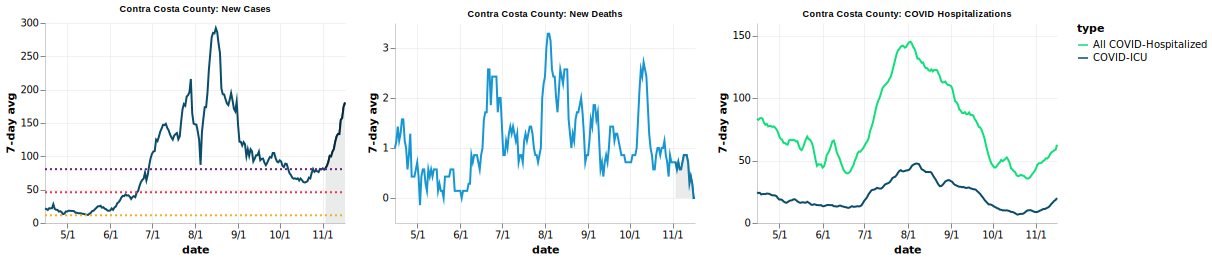

In [6]:
c = "Contra Costa"
plot_charts(jhu, hospitalizations, c)

<a id='imperial'></a>

## Imperial, CA

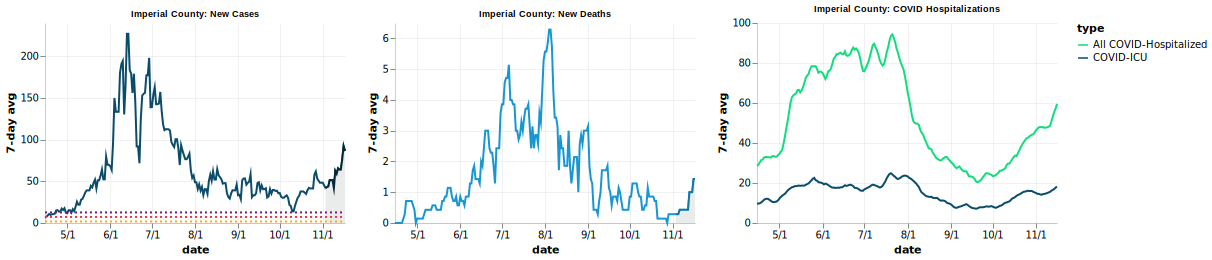

In [7]:
c = "Imperial"
plot_charts(jhu, hospitalizations, c)

<a id='marin'></a>

## Marin, CA

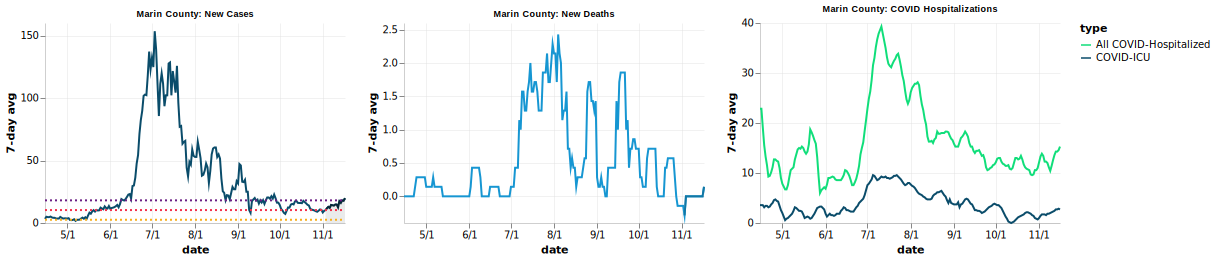

In [8]:
c = "Marin"
plot_charts(jhu, hospitalizations, c)

<a id='orange'></a>

## Orange, CA

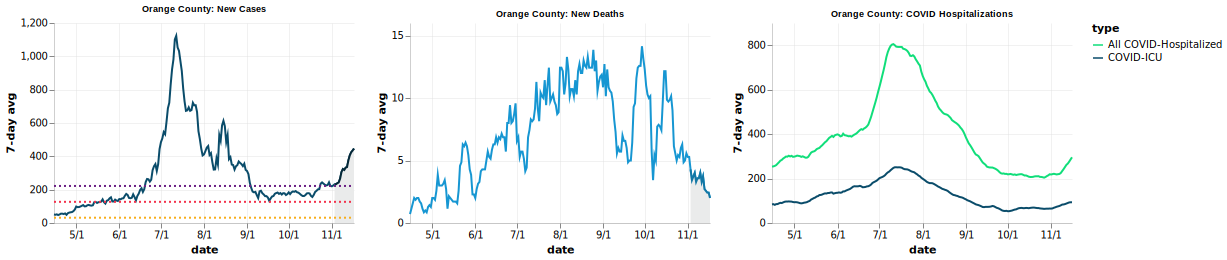

In [9]:
c = "Orange"
plot_charts(jhu, hospitalizations, c)

<a id='riverside'></a>

## Riverside, CA

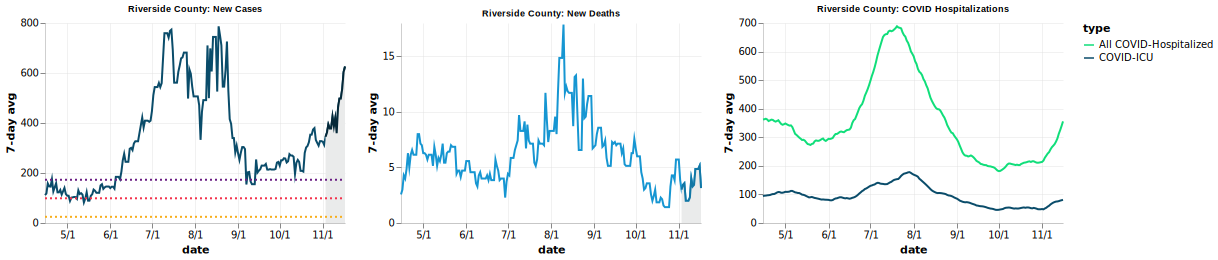

In [10]:
c = "Riverside"
plot_charts(jhu, hospitalizations, c)

<a id='san_bernardino'></a>

## San Bernardino, CA

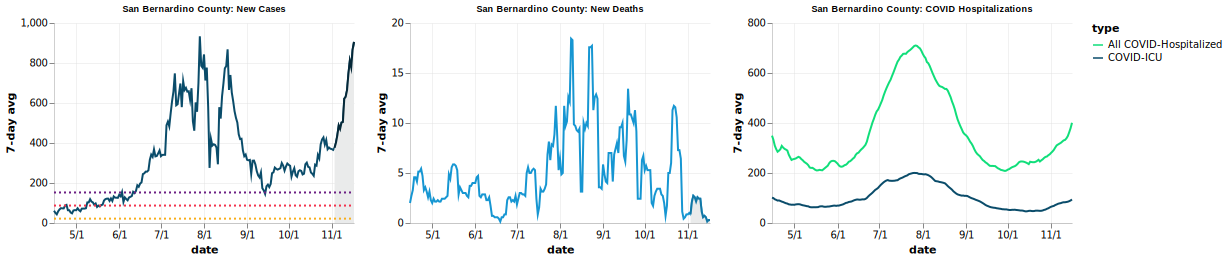

In [11]:
c = "San Bernardino"
plot_charts(jhu, hospitalizations, c)

<a id='san_diego'></a>

## San Diego, CA

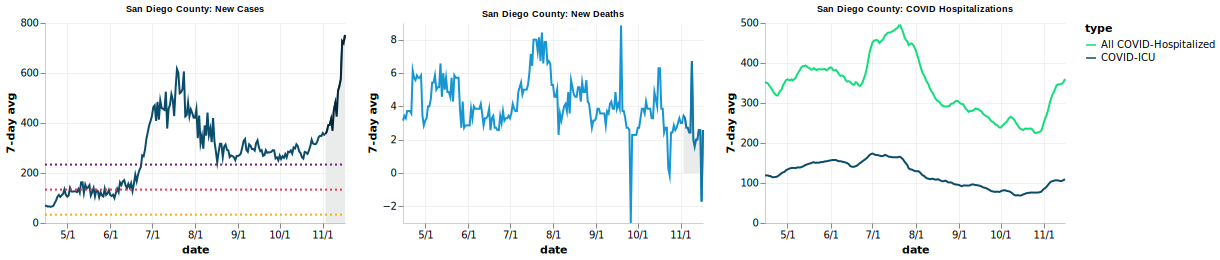

In [12]:
c = "San Diego"
plot_charts(jhu, hospitalizations, c)

<a id='san_francisco'></a>

## San Francisco, CA

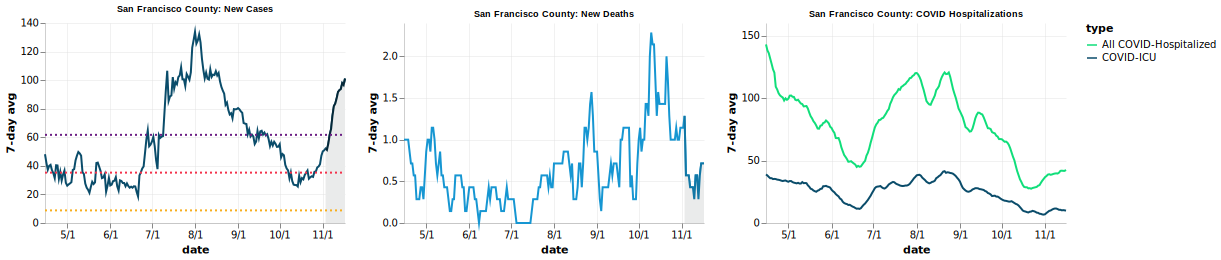

In [13]:
c = "San Francisco"
plot_charts(jhu, hospitalizations, c)

<a id='san_mateo'></a>

## San Mateo, CA

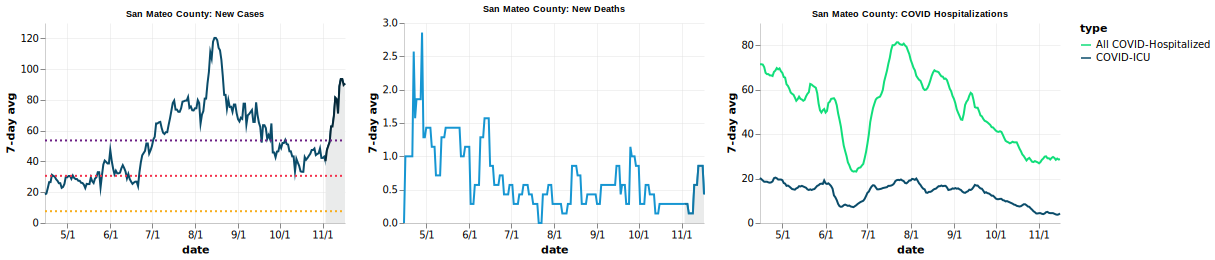

In [14]:
c = "San Mateo"
plot_charts(jhu, hospitalizations, c)

<a id='santa_barbara'></a>

## Santa Barbara, CA

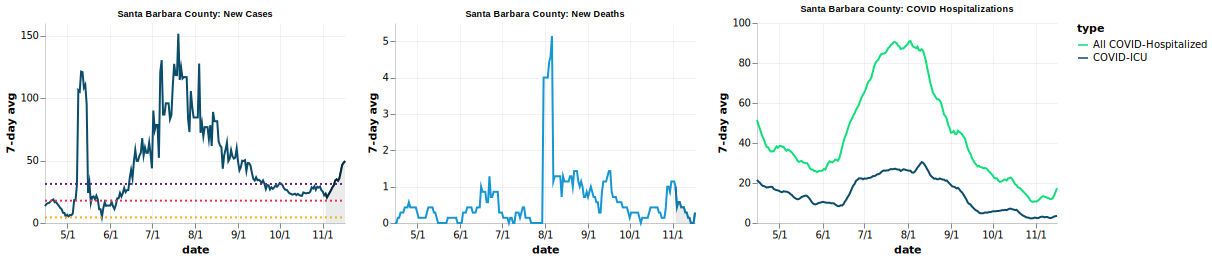

In [15]:
c = "Santa Barbara"
plot_charts(jhu, hospitalizations, c)

<a id='santa_clara'></a>

## Santa Clara, CA

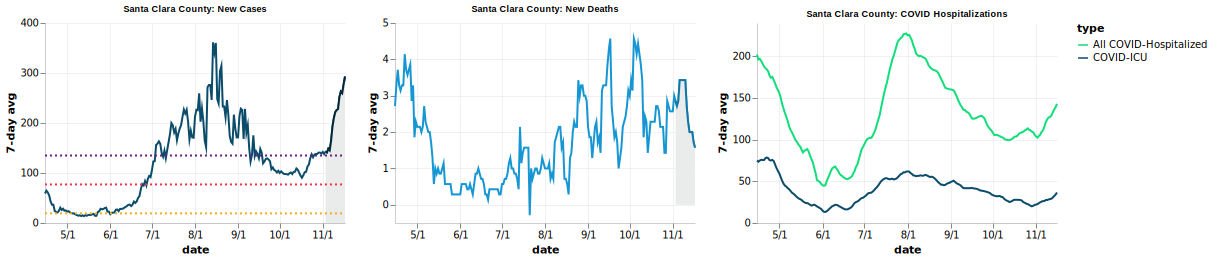

In [16]:
c = "Santa Clara"
plot_charts(jhu, hospitalizations, c)

<a id='santa_cruz'></a>

## Santa Cruz, CA

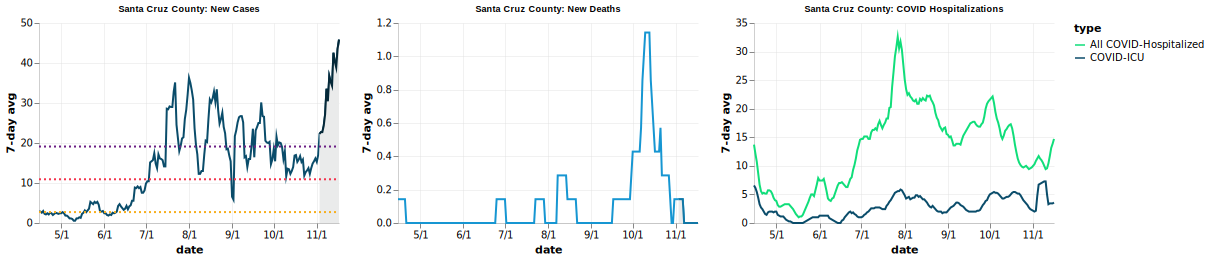

In [17]:
c = "Santa Cruz"
plot_charts(jhu, hospitalizations, c)

<a id='solano'></a>

## Solano, CA

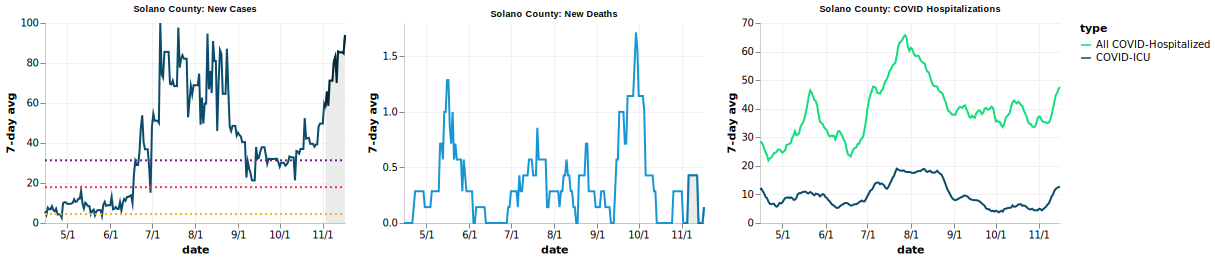

In [18]:
c = "Solano"
plot_charts(jhu, hospitalizations, c)

<a id='ventura'></a>

## Ventura, CA

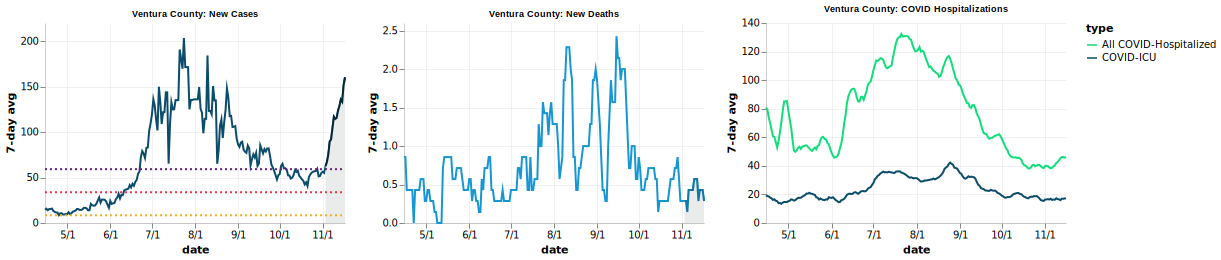

In [19]:
c = "Ventura"
plot_charts(jhu, hospitalizations, c)